<a href="https://colab.research.google.com/github/AlonWolfi/kaggle--nlp-getting-started/blob/master/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
if 'google.colab' in str(get_ipython()):
    import os, time
    SECONDS_TO_WAIT = 3
    GIT_USER = 'AlonWolfi'
    KAGGLE_COMPETITION = 'nlp-getting-started'

    print('Running on CoLab')
    if (os.path.exists('sample_data')):
        !rm -rf sample_data && rm -rf ./*
        git_link = f'https://github.com/{GIT_USER}/kaggle--{KAGGLE_COMPETITION}.git'
        !git clone $git_link ./

    print('Downloading kaggle dataset')
    if not os.path.exists('data'):
        while(not os.path.exists('kaggle.json')):
            print('Waiting for kaggle.json')
            # !read -t SECONDS_TO_WAIT -n 1
            time.sleep(SECONDS_TO_WAIT)

        if os.path.exists('kaggle.json'):
            !mkdir /root/.kaggle
            !mv kaggle.json /root/.kaggle
            !kaggle competitions download -p data -c $KAGGLE_COMPETITION
    
        print('Unzipping dataset')
        import os
        for file in os.listdir("data"):
            if file.endswith(".zip"):
                print(file)
                !unzip data/$file -d data
                !rm data/$file

    print('pip installations')
    !pip install -q pycountry
    !pip install -q shap
    !pip install -q lime
    !pip install -q eli5
    !pip install -q skorch
    !pip install -q optuna
else:
    print('Not running on CoLab')

Running on CoLab
Init kaggle
pip installations


In [159]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
import shap, lime, eli5
shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment

In [160]:
from utils.metric_utils import HardMetric
from sklearn.metrics import f1_score

In [167]:
VALIDATION = False
SAMPLE = True
SAMPLE_FRAC = 0.3
final_metric = HardMetric(f1_score)

## Load data

In [192]:
from pathlib import Path
DATA_DIR = Path('data')
RESULTS_DIR = Path('results')
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

In [169]:
train = pd.read_csv(DATA_DIR / 'train.csv',index_col = 'id')
test = pd.read_csv(DATA_DIR / 'test.csv',index_col = 'id')
data = pd.concat([train, test]).drop(columns = 'target')
sample_test = pd.read_csv(DATA_DIR / 'sample_submission.csv',index_col = 'id')

In [170]:
from sklearn.model_selection import train_test_split
if VALIDATION:
    if SAMPLE:
        data = train.sample(frac = SAMPLE_FRAC)
    else:
        data = train
    train, test = train_test_split(data, train_size=0.7, shuffle=True)
    y_test = test['target']
    test = test.drop(columns = 'target')
else:
    train = train.sample(frac = 1.)

In [171]:
train.shape, test.shape

((7613, 4), (3263, 3))

# Feature Extraction

In [172]:
from utils.feature_utils import *

## Keyword

In [173]:
from feature_extraction.keyword import process_keyword

keyword = data['keyword']
X_keyword = process_keyword(keyword)
X_keyword.sample(10)

,keyword_OH_ablaze,keyword_OH_accident,keyword_OH_aftershock,keyword_OH_airplane%20accident,keyword_OH_ambulance,keyword_OH_annihilated,keyword_OH_annihilation,keyword_OH_apocalypse,keyword_OH_armageddon,keyword_OH_army,keyword_OH_arson,keyword_OH_arsonist,keyword_OH_attack,keyword_OH_attacked,keyword_OH_avalanche,keyword_OH_battle,keyword_OH_bioterror,keyword_OH_bioterrorism,keyword_OH_blaze,keyword_OH_blazing,keyword_OH_bleeding,keyword_OH_blew%20up,keyword_OH_blight,keyword_OH_blizzard,keyword_OH_blood,keyword_OH_bloody,keyword_OH_blown%20up,keyword_OH_body%20bag,keyword_OH_body%20bagging,keyword_OH_body%20bags,keyword_OH_bomb,keyword_OH_bombed,keyword_OH_bombing,keyword_OH_bridge%20collapse,keyword_OH_buildings%20burning,keyword_OH_buildings%20on%20fire,keyword_OH_burned,keyword_OH_burning,keyword_OH_burning%20buildings,keyword_OH_bush%20fires,...,keyword_OH_storm,keyword_OH_stretcher,keyword_OH_structural%20failure,keyword_OH_suicide%20bomb,keyword_OH_suicide%20bomber,keyword_OH_suicide%20bombing,keyword_OH_sunk,keyword_OH_survive,keyword_OH_survived,keyword_OH_survivors,keyword_OH_terrorism,keyword_OH_terrorist,keyword_OH_threat,keyword_OH_thunder,keyword_OH_thunderstorm,keyword_OH_tornado,keyword_OH_tragedy,keyword_OH_trapped,keyword_OH_trauma,keyword_OH_traumatised,keyword_OH_trouble,keyword_OH_tsunami,keyword_OH_twister,keyword_OH_typhoon,keyword_OH_upheaval,keyword_OH_violent%20storm,keyword_OH_volcano,keyword_OH_war%20zone,keyword_OH_weapon,keyword_OH_weapons,keyword_OH_whirlwind,keyword_OH_wild%20fires,keyword_OH_wildfire,keyword_OH_windstorm,keyword_OH_wounded,keyword_OH_wounds,keyword_OH_wreck,keyword_OH_wreckage,keyword_OH_wrecked,keyword_isna
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9864,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7781,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [174]:
keyword.sample(10)

id
10247              volcano
8016              refugees
1616                bombed
1685     bridge%20collapse
6368              hostages
5132                 fatal
4277              drowning
1491           body%20bags
3984           devastation
469             armageddon
Name: keyword, dtype: object

## Text

In [175]:
from feature_extraction.text import *

text = data['text']
X_text = process_text(text)
X_text.sample(10)

,text_count_urls,text_count_large_words,text_count_small_words,text_count_words,text_count_large_words_frac,text_our,text_deeds,text_are,text_the,text_reason,text_of,text_this,text_earthquake,text_may,text_allah,text_forgive,text_us,text_all,text_forest,text_fire,text_near,text_la,text_ronge,text_sask,text_canada,text_residents,text_asked,text_to,text_shelter,text_in,text_place,text_being,text_notified,text_by,text_officers,text_no,text_other,text_evacuation,text_or,text_orders,...,text_gums,text_therapist,text_ftcarsonpao,text_carsonmwr,text_rental,text_fml,text_dukeskywalker,text_facialabuse,text_competetion,text_xxxmrbootleg,text_claudiomeloni,text_penetrator,text_upload,text_whatstheimportantvideo,text_uneven,text_herologist,text_janisctv,text_manner,text_parcel,text_rfc,text_ease,text_yakuboobs,text_smackdown,text_tyme,text_thrillhho,text_jsyk,text_abt,text_remus,text_slumped,text_stighefootball,text_begovic,text_reserve,text_hattrick,text_ebolaoutbreak,text_ala,text_rajman,text_hasaka,text_risen,text_fasteners,text_xrwn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5021,2,2,12,17,0.116959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5632,1,3,10,15,0.198675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2136,0,9,1,12,0.743802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3935,0,2,4,8,0.246914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5273,0,2,21,26,0.076628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3691,0,1,21,23,0.043290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1683,0,6,15,22,0.271493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0,3,5,11,0.270270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9736,0,3,15,21,0.142180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [176]:
raw_vs_processed(text, preprocess_text).sample(10).apply(lambda s: s.apply(print), axis = 1)
pass

Every time I get on the news I see more sadness and needless death. To all my first responders still on shift tonight go home safe. ??????????
every time i get on the news i see more sadness and needless death  to all my first responders still on shift tonight go home safe            
'@GoogleFacts: Wounds heal faster if you lick them. Tears also help them heal as well.'  I know right even thou it seems stupid when lickin
  googlefacts  wounds heal faster if you lick them  tears also help them heal as well    i know right even thou it seems stupid when lickin
Still rioting in a couple of hours left until I have to be up for class.
still rioting in a couple of hours left until i have to be up for class 
ohH NO FUKURODANI DIDN'T SURVIVE THE APOCALYPSE BOKUTO FEELS HORRIBLE  my poor boy my ppor child
ohh no fukurodani didn t survive the apocalypse bokuto feels horrible  my poor boy my ppor child
@_NickSimboli_ u know what I'd say she's the equivalent of strawberries in this case I would s

## location

In [177]:
from feature_extraction.location import process_location, preprocess_location

location = data['location']
X_location = process_location(location)
X_location.sample(10)

,location_nan,location_birmingham,location_est,location_september,location_bristol,location_estonia,location_africa,location_philadelphia,location_pa,location_panama,location_london,location_uk,location_pretoria,location_world,location_wide,location_paranaque,location_city,location_live,location_on,location_webcam,location_milky,location_way,location_greensboro,location_north,location_carolina,location_england,location_sheffield,location_township,location_ohio,location_india,location_barbados,location_anaheim,location_abuja,location_usa,location_united,location_states,location_south,location_sao,location_paulo,location_brazil,...,location_ggian,location_srkian,location_harvard,location_square,location_herbville,location_bristow,location_algonquin,location_sawangan,location_enemy,location_mds,location_canton,location_range,location_sky,location_limit,location_orth,location_sg,location_garrus,location_yyc,location_tonawanda,location_er,location_mood,location_eritrea,location_frm,location_jerz,location_brantford,location_wenatchee,location_mii,location_gauteng,location_heidelberg,location_ratanda,location_lesotho,location_inwood,location_would,location_rather,location_philippians,location_deep,location_libland,location_reiss,location_acey,location_islanddåçtorontoåè
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
raw_vs_processed(location, preprocess_location).sample(10)

,raw,process
id,,
3387,NaN,nan
4044,Atlanta,atlanta
2489,"Johannesburg, South Africa",johannesburg south africa
10440,YYC,yyc
166,304,
3658,"Alvin, TX",alvin tx
1355,"Paterson, New Jersey",paterson new jersey
10545,NaN,nan
6177,NaN,nan


## combine

In [179]:
X_all = X_keyword.join(X_text).join(X_location)

X_train = X_all.loc[train.index]
y_train = train['target']
X_test = X_all.loc[test.index]

# Feature Selection

In [180]:
from feature_selection.feature_selection import select_features

final_cols = select_features(X_train, y_train)
X_train = X_train[final_cols]
X_test = X_test[final_cols]

started with 23875 features
finished with 2886 features


# Modeling

In [181]:
from models import *

In [182]:
# clf = LogisticModel(max_iter = 1000, C=0.8)

# clf = LGBMModel(n_estimators=10, max_depth=5, colsample_bytree=0.2)

clf = XGBModel(n_estimators=30, max_depth=5, colsample_bytree=0.8)

# clf = SkorchModel(n_features)

# clf = KerasModel()

## ensemble

In [183]:
# from sklearn.ensemble import StackingClassifier
# from utils.model_utils import EnsembleClassifier

# base_estimators = [
#     ('logistic', LogisticRegression(max_iter=1000, C = 0.1, solver = 'lbfgs')), 
#     ('lgbm', LGBMClassifier(**{'n_estimators': 100, 'max_depth': 5, 'colsample_bytree': 0.8}))
# ]
# clf = StackingClassifier(base_estimators, final_estimator = LGBMClassifier(n_estimators=10), stack_method='predict_proba')

## Optuna

In [184]:
# from models import *

# from models.optuna import OptunaCV
# clf = OptunaCV.optimize(
#     X_train,
#     y_train,
#     estimators= [XGBModel, LGBMModel, KerasModel],
#     metric=final_metric,
#     n_trials = 15,
#     n_jobs = -1
# )

In [185]:
clf

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.8, gamma=0, learning_rate=0.1,
         max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
         n_estimators=30, n_jobs=1, nthread=None, objective='binary:logistic',
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=None, silent=None, subsample=1, verbosity=1)

### LSTM

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from models.base_model import BaseModel


def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


class LSTMModel(BaseModel):
    metric = custom_f1

    def __init__(self, **sk_params):
        super().__init__(**sk_params)
        self.n_hidden = n_hidden

    def create_base(self, **sk_params):
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(self.n_hidden, activation='relu'))
            #     model.add(Dense(8, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[custom_f1])
            return model

        # create model
        clf = KerasClassifier(build_fn=create_model, **sk_params)
        return clf

    def fit(self, X, y=None, *args, **kwargs):
        return super(KerasModel, self).fit(X.values, y.values, *args, **kwargs)

    def predict_proba(self, X, *args, **kwargs):
        return super().predict_proba(X.values, *args, **kwargs)

    @classmethod
    def optuna_params(cls, trial):
        return {
            'n_hidden': trial.suggest_int("n_hidden", 2, 32),
            'epochs': trial.suggest_int("epochs", 2, 32),
            'batch_size': trial.suggest_int("batch_size", 16, 64),
            'verbose': 0
        }



# from sklearn.pipeline import Pipeline

# clf = Pipeline([
#         ('tokenizer', Tokenizer),
#         ()
# ])

In [277]:
from feature_extraction.text import preprocess_text
text = preprocess_text(train['text'])


In [270]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

tokenized_text = text.apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


id
6232       [remove, the, and, linkury, browser, hijacker]
5818    [heavy, rain, and, lightning, overhead, in, oa...
9145    [isis, claims, responsibility, for, saudi, mos...
5828                            [hail, the, new, caesars]
2482    [stupid, women, nearly, collided, into, me, to...
                              ...                        
3810         [detonate, feat, m, o, p, by, apollo, brown]
578                          [sayn, ae, angel, or, arson]
8311    [johnfugelsang, again, i, didn, t, say, it, wa...
9303    [ended, today, s, staff, meeting, with, the, t...
2001    [so, apparently, there, were, bush, fires, nea...
Name: text, Length: 7613, dtype: object

In [285]:
# from modeling.model import Model
# from modeling.dataset import Dataset
# from modeling.train import train
# from modeling.tokenizer import tokenize_text

# tokenized_text = text.apply(tokenize_text)
# args = {
#     'max_epochs' : 5,
#     'batch_size' : 256,
#     'sequence_length' : 5,
#     'max_len' : 100,
    
# }

# dataset = Dataset(tokenized_text,**args)
# model = Model(dataset)

# train(dataset, model, args)
# # model.load_state_dict(state_dict)

Started dataset with 16121 words


KeyError: ignored

Model(
  (embedding): Embedding(16121, 32)
  (lstm): LSTM(32, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=16121, bias=True)
)

## Fitting

In [186]:
clf.fit(X_train,y_train)
y_train_pred_score = clf.predict_proba(X_train)[:, 1]
y_pred_score = clf.predict_proba(X_test)[:, 1]
th = 0.5

### Threshold choosing

In [188]:
from sklearn.model_selection import cross_val_predict
from utils.cv_utils import cross_val_predict_proba

xx_train, xx_val, yy_train, yy_val = train_test_split(X_train, y_train, train_size=0.7, shuffle=True)

clf.fit(xx_train,yy_train)
yy_val_pred_score = clf.predict_proba(xx_val)[:, 1]
th = final_metric.get_thresh(yy_val, yy_val_pred_score)
print(f'threshold changed to {th}')

yy_val_pred = (yy_val_pred_score > th).astype(int)
val_score = final_metric.metric(yy_val, yy_val_pred)

threshold changed to 0.386


### predict

In [189]:
y_pred = (y_pred_score > th).astype(int)
y_train_pred = (y_train_pred_score > th).astype(int)

# (Validation) Evaluation

In [190]:
if VALIDATION:
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
    import matplotlib.pyplot as plt
    print(f'train score:\t {final_metric.metric(y_train, y_train_pred)}')
    print(f'test score:\t {final_metric.metric(y_test, y_pred)}')
    plot_roc_curve(clf, X_train, y_train, name='train')
    plot_roc_curve(clf, X_test, y_test, name='val', ax = plt.gca())
    plot_precision_recall_curve(clf, X_train, y_train, name='train')
    plot_precision_recall_curve(clf, X_test, y_test, name='val', ax = plt.gca())
    plot_confusion_matrix(clf, X_test, y_test)

# (Pred) Submit Results

In [253]:
def get_submissions(kaggle_api=kaggle_api):
    past_submissions = pd.DataFrame(kaggle_api.competitions_submissions_list(COMPETITION))
    while(past_submissions.iloc[0].status == 'pending'):
        past_submissions = pd.DataFrame(kaggle_api.competitions_submissions_list(COMPETITION))
    good_past_submissions = past_submissions[(~past_submissions['description'].isna()) & (past_submissions['description'] != '')]
    past_submissions_params  = good_past_submissions['description'].astype(str).apply(eval)
    for k in past_submissions_params.iloc[0].keys():
        past_submissions.loc[good_past_submissions.index, k] = past_submissions_params.loc[good_past_submissions.index].apply(lambda d: d[k])
    current_submission, past_submissions = past_submissions.iloc[0], past_submissions.iloc[1:]
    return current_submission, past_submissions

if not VALIDATION:
    import datetime
    import kaggle
    kaggle_api = kaggle.KaggleApi()
    kaggle_api.authenticate() 
    
    current_time = str(datetime.datetime.now())[:-7].replace(' ', '__').replace('-', '_').replace(':', '_')
    final_result = pd.Series(data = y_pred, index = test.index, name='target').to_frame()
    submission_path = RESULTS_DIR / f'results_{current_time}.csv'
    final_result.to_csv(submission_path)
    
    desc = str({
        "clf" : str(clf),
        "params" : clf.get_params(),
        "val_score" : val_score,
    })
    kaggle_api.competition_submit(submission_path, desc, KAGGLE_COMPETITION)
    current_submission, past_submissions = get_submissions()
    print(f'Current score: {current_submission["publicScore"]}')
    print(f'Best score so far: {past_submissions["publicScore"].max()}')
    print(f'Current val_score: {current_submission["val_score"]}')
    print(f'Best val_score so far: {past_submissions["val_score"].max()}')

100%|██████████| 22.2k/22.2k [00:09<00:00, 2.50kB/s]


Current score: 0.67054
Best score so far: 0.79773
Current val_score: 0.6669599648042235
Best val_score so far: 0.6669599648042235


In [255]:
y_pred.sum(), y_pred.shape[0]

(1911, 3263)

# Feature Importances

## feature_importances_

In [256]:
clf.feature_importance(X_train.columns)

text_flared            0.000000
text_boxed             0.000000
text_soothmyslumber    0.000000
text_aaaaaand          0.000000
text_shakes            0.000000
                         ...   
text_selects           0.019598
text_ryt               0.021975
text_proud             0.022968
text_affects           0.026108
text_count_urls        0.105913
Length: 2886, dtype: float32

## shap

In [258]:
explainer = shap.TreeExplainer(clf._base_clf, X_train)
shap_values = explainer.shap_values(X_test)

 93%|=================== | 3036/3263 [00:13<00:00]       

In [259]:
idx = np.random.choice(X_test.shape[0], size = 1)
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx], link="logit")

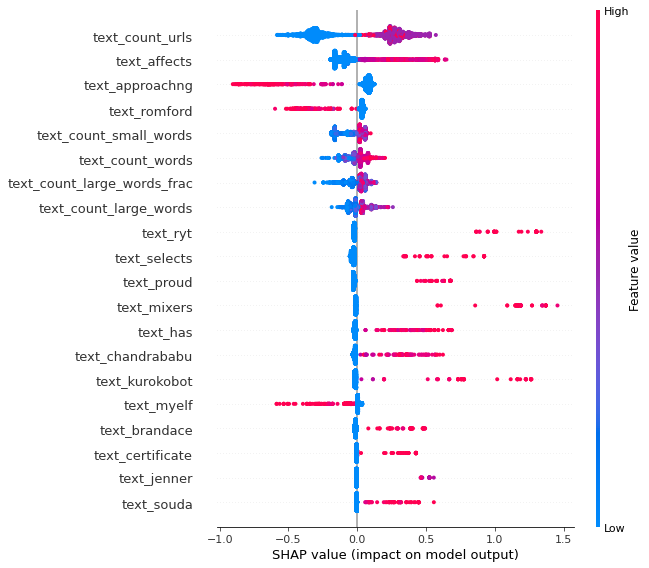

In [260]:
shap.summary_plot(shap_values, X_test)

# Error Analysis

In [261]:
sns.distplot(y_pred_score[y_test==1], label = 'P')
sns.distplot(y_pred_score[y_test==0], label = 'N')
plt.legend()

IndexError: ignored

In [ ]:
top_FP = y_test[y_test==0].iloc[np.argpartition(y_pred_score[y_test==0], -4)[-4:][::-1]].index.tolist()
top_FN = y_test[y_test==1].iloc[np.argpartition(y_pred_score[y_test==1], 4)[:4]].index.tolist()

In [ ]:
top_FP

In [43]:
shap_values = {k: shap_values[idx,:] for idx, k in enumerate(X_test.index)}

NameError: ignored

In [44]:
data.loc[top_FN]

,keyword,location,text,target
id,,,,
7183,mudslide,"London, England",@new_hart2010 #mudslide... nuff said #GBBO,1
3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
7698,panicking,NaN,@Dirk_NoMissSki yea but if someone faints why ...,1
9314,survive,NaN,A country Chim can survive!,1


In [45]:
ididid = top_FN[0]

In [46]:
data.loc[top_FN[1]].text

'So you have a new weapon that can cause un-imaginable destruction.'

In [ ]:
X_test.loc[[top_FN[0]]]

,text_count_large_words,text_count_small_words,text_count_words,text_count_large_words_frac,text_its,text_left,text_to,text_if,text_follow,text_casualties,...,location_through,location_aracaju,location_sofa,location_upstate,location_clayton,location_dundalk,location_arvada,location_chandler,location_dani,location_vcu
id,,,,,,,,,,,,,,,,,,,,,
4895,1,6,8,0.123457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[top_FN[0]], X_test.loc[[top_FN[0]]], link="logit")